### ECGbe-GAN: A novel deep learning approach for eliminating ECG interference from EMG data
Lucas Haberkamp<sup>1,2,3</sup> Charles A. Weisenbach<sup>1,2</sup> Peter Le<sup>4</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Oak Ridge Institute for Science and Education, Oak Ridge, TN, USA   
<sup>3</sup>Leidos, Reston, VA, USA   
<sup>4</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA 

#### This notebook generates a synthetic EMG dataset that is corrupted with ECG 

In [97]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

Define Butterworth filter function

In [98]:
def butterfilter(x, Fc, Fs, type):
    Wn = np.asarray(Fc)/np.asarray(Fs/2)
    b, a = signal.butter(2, Wn, type)
    return signal.filtfilt(b,a,x)

Define helper function to load in EMG dataset

In [99]:
def extractdf(data_path, header):
    file_list, df_list = [], [] # initialize lists
    for filename in sorted(os.listdir(data_path)):
        f = os.path.join(data_path, filename) 
        if os.path.splitext(filename)[1] == '.csv':
            current_file = os.path.splitext(filename)[0] # get the identifier of the participant from the file
            file_list.append(current_file)  
            tmp_df = pd.read_csv(f, header=header)
            df_list.append(tmp_df)
    return df_list, file_list

In [100]:
# Specify paths
syn_path = '../../Data/Raw Synthetic Data'

# Extract the data as dataframes stored into lists
syn_data_list, syn_file_list = extractdf(syn_path, header=4)

print("Files in the synthetic dataset:", syn_file_list)

Files in the synthetic dataset: ['Run_number_58_Plot_and_Store_Rep_1.1', 'Run_number_58_Plot_and_Store_Rep_10.10', 'Run_number_58_Plot_and_Store_Rep_2.2', 'Run_number_58_Plot_and_Store_Rep_3.3', 'Run_number_58_Plot_and_Store_Rep_4.4', 'Run_number_58_Plot_and_Store_Rep_5.5', 'Run_number_58_Plot_and_Store_Rep_6.6', 'Run_number_58_Plot_and_Store_Rep_7.7', 'Run_number_58_Plot_and_Store_Rep_8.8', 'Run_number_58_Plot_and_Store_Rep_9.9']


In [101]:
# Set hyperparameters
Fs = 1920
window_size = 800

# Initialize scaler object
scaler = StandardScaler()

Automated R Peak Detection as described in "Costa Junior, J.D., de Seixas, J.M., Miranda de Sá, A.M.F.L., 2019. A template subtraction method for reducing electrocardiographic artifacts in EMG signals of low intensity. Biomedical Signal Processing and Control 47, 380-386."

In [102]:
def getlabels(ECG):
  rect = pd.Series(np.abs(ECG))
  ma1 = rect.rolling(window=1920, center=True, min_periods=1).mean()
  ma2 = rect.rolling(window=192, center=True, min_periods=1).mean()

  curr_label = np.ones(shape=(ECG.shape[0], 1))
  curr_label[ma2 > ma1 + 1e-6] = 0
  
  return curr_label

Create EMG and ECG datasets, along with corresponding labels of QRS locations.

In [103]:
# Concatenate Bicep EMG data across trials
EMG_data = pd.concat([syn_data_list[0].iloc[:,1], syn_data_list[1].iloc[:,1], 
    syn_data_list[4].iloc[:,1], syn_data_list[5].iloc[:,1],
    syn_data_list[6].iloc[:,1], syn_data_list[7].iloc[:,1],
    syn_data_list[8].iloc[:,1], syn_data_list[9].iloc[:,1]
], axis=0)

# Resample to 1920-Hz
EMG_data = signal.resample_poly(EMG_data, Fs, 2148)

# Butterworth low-pass filter at 500-Hz cutoff
EMG_data = butterfilter(EMG_data, Fc=500, Fs=Fs, type='low')

EMG_gradient = np.abs(np.gradient(EMG_data))

# Concatenate ECG data across lying supine trials
ECG_data = pd.concat([syn_data_list[2].iloc[:,3], syn_data_list[3].iloc[:,3]], axis=0)
# Resample to 1920-Hz
ECG_data = signal.resample_poly(ECG_data, Fs, 2148)

# Butterworth low-pass filter at 50-Hz cutoff
filt_ECG = butterfilter(ECG_data, Fc=50, Fs=Fs, type='low')
# Obtain QRS locations
QRS_label = getlabels(filt_ECG)

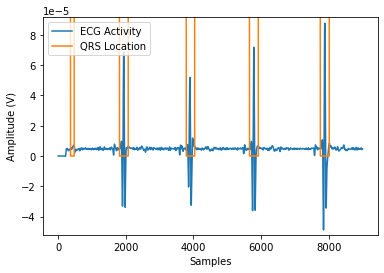

In [104]:
plt.plot(filt_ECG[:9000])
plt.plot(QRS_label[:9000])
plt.ylim([np.min(filt_ECG), np.max(filt_ECG)])
plt.xlabel('Samples')
plt.ylabel('Amplitude (V)')
plt.legend(['ECG Activity', 'QRS Location'])
plt.show()

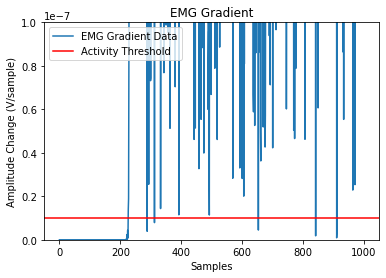

In [105]:
plt.plot(EMG_gradient[:1000])
plt.axhline(y=1e-8, color='r')
plt.ylim([0, 1e-7])
plt.title('EMG Gradient')
plt.legend(['EMG Gradient Data', 'Activity Threshold'])
plt.xlabel('Samples')
plt.ylabel('Amplitude Change (V/sample)')
plt.show()

Function to obtain the synthetic dataset

In [106]:
def get_dataset(dataset_size):
    x = []
    y = []
    labels = []
    
    count = 0    
    while count < dataset_size:
        i = np.random.randint(window_size, EMG_data.shape[0]) # random biceps EMG index
        if np.all(EMG_gradient[i-window_size:i]>1e-8): # ensure the EMG data is from a contraction
            while True:
                rng_ECG_int = np.random.randint(window_size, filt_ECG.shape[0]) # random HR index
                if np.max(filt_ECG[rng_ECG_int-window_size+200:rng_ECG_int-200]) > 4e-5: # ensure the R peak is a sufficient amplitude
                    curr_ECG = filt_ECG[rng_ECG_int-window_size:rng_ECG_int] # obtain the hr data
                    curr_label = QRS_label[rng_ECG_int-window_size:rng_ECG_int] # obtain the label for the hr segment
                    break
        
            curr_ECG = curr_ECG - np.mean(curr_ECG) # DC offset on the hr data
            curr_ECG = np.expand_dims(curr_ECG, axis=1)

            curr_EMG = EMG_data[i-window_size:i] # Use the rng biceps EMG index to obtain a window of biceps EMG data
            curr_EMG = curr_EMG - np.mean(curr_EMG) # DC offset on the biceps EMG data
            curr_EMG = np.expand_dims(curr_EMG, axis=1)
            
            # Assess the ratio of the average rectified biceps muscle activity : ECG R-peak
            curr_ratio = np.mean(np.abs((curr_EMG)))/np.max(np.abs(curr_ECG))
            rng_ratio = np.random.randint(2, 15) # Random ratio for muscle activity : cardiac activity
            # Adjust the bicep's EMG to be a specific ratio compared to cardiac activity
            curr_EMG = (curr_EMG / curr_ratio) / rng_ratio 

            curr_inputs = curr_EMG + curr_ECG # Add scaled bicep's EMG and cardiac activity
            curr_outputs = curr_EMG

            # Scale inputs/outputs with MinMaxScaler
            norm_inputs = scaler.fit_transform(curr_inputs) 
            norm_outputs = scaler.transform(curr_outputs)
            
            x.append(norm_inputs)
            y.append(norm_outputs)
            labels.append(curr_label)

            count += 1


    x = np.array(x)
    y = np.array(y)
    labels = np.array(labels)

    print("x_shape:", x.shape)
    print("y_shape:", y.shape)
    print("label_shape:", labels.shape)
    return x, y, labels

In [107]:
x, y, label = get_dataset(dataset_size=6000)

x_shape: (6000, 800, 1)
y_shape: (6000, 800, 1)
label_shape: (6000, 800, 1)


Signal-Noise calculation as described in "Abbaspour, S., Fallah, A., 2014. Removing ECG artifact from the surface EMG signal using adaptive subtraction technique. Journal of biomedical physics & engineering 4, 33."

In [108]:
def SNR(y_true, y_pred):
    diff = y_true - y_pred
    
    num = np.var(y_true)
    den = np.var(diff)

    # calculate the SNR in dB
    snr = 10*np.log10(num/den)
    return snr

Calculate the mean ± standard deviation of the dataset's SNR 

In [109]:
snr_all = []
for i in range(x.shape[0]):
    snr_all.append(SNR(y[i],x[i]))

snr_all = np.array(snr_all)

print("Mean:", np.mean(snr_all))
print("STD:", np.std(snr_all))

Mean: -0.9995309529921624
STD: 5.032183557989263


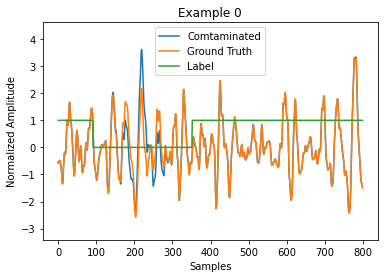

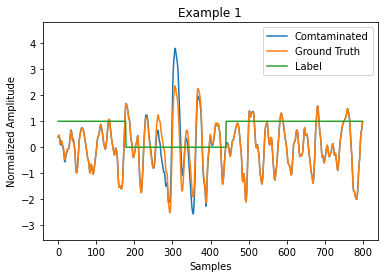

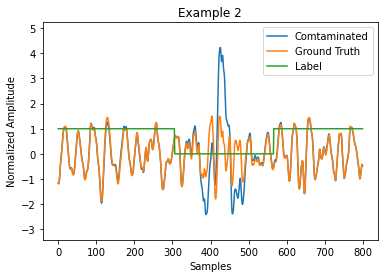

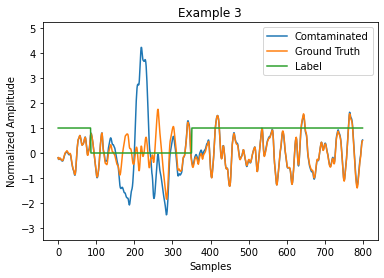

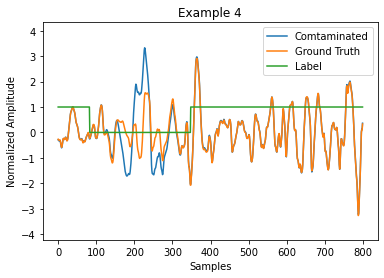

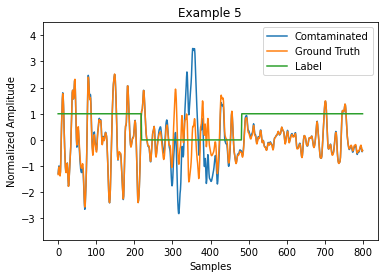

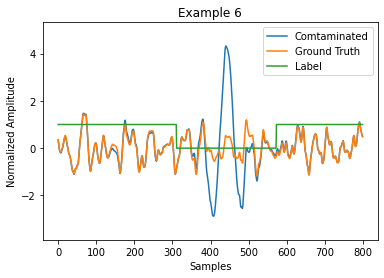

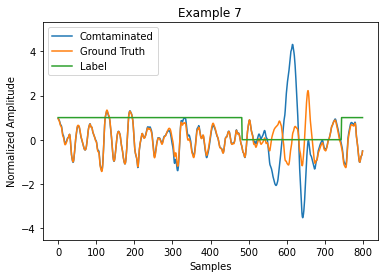

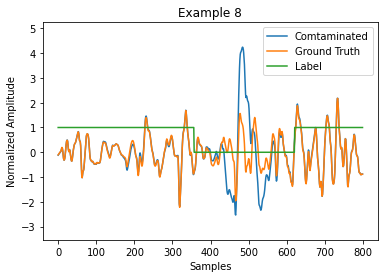

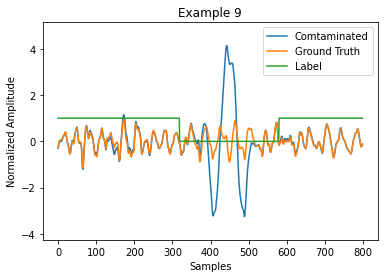

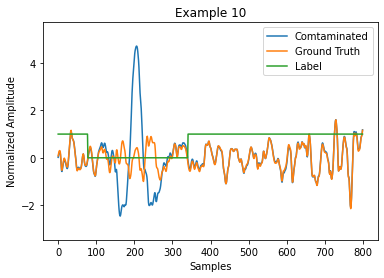

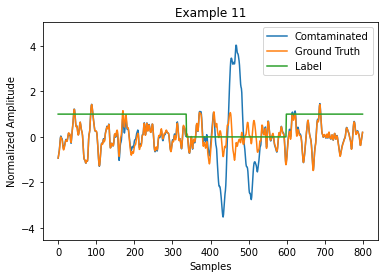

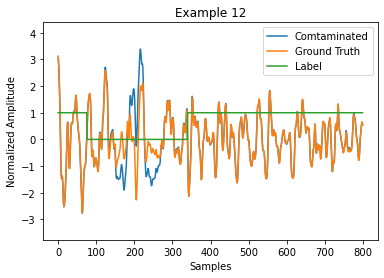

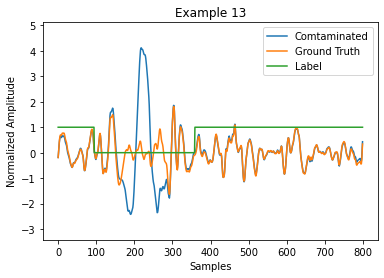

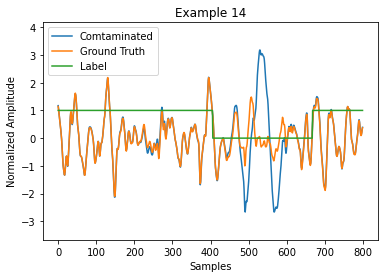

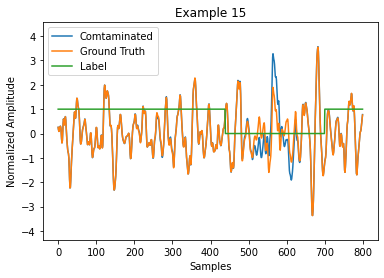

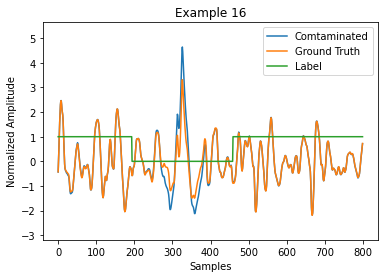

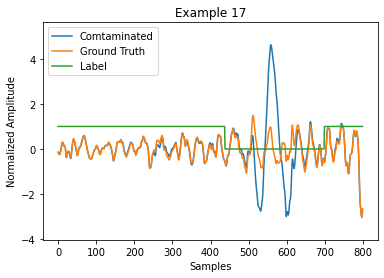

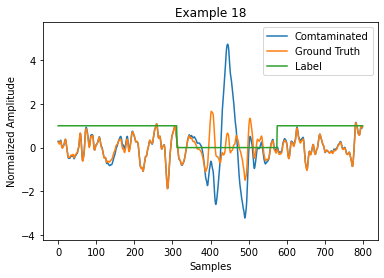

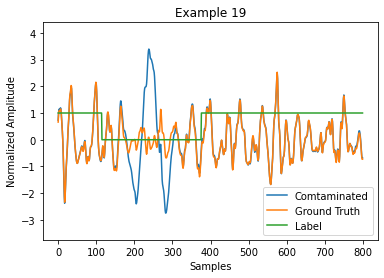

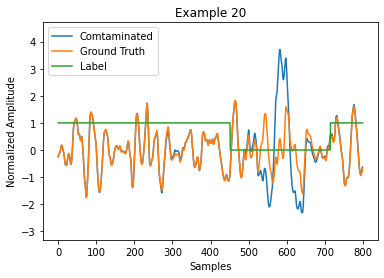

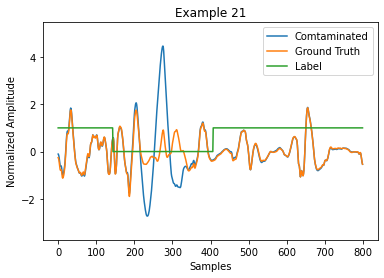

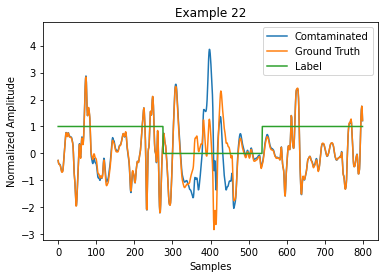

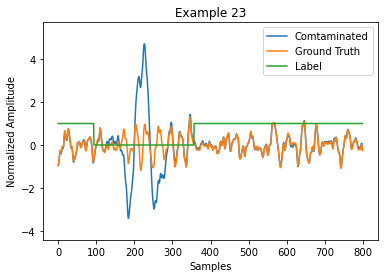

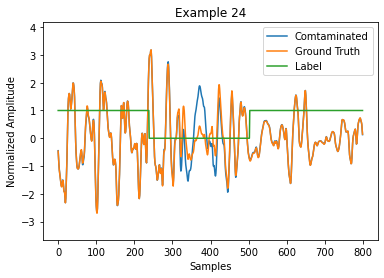

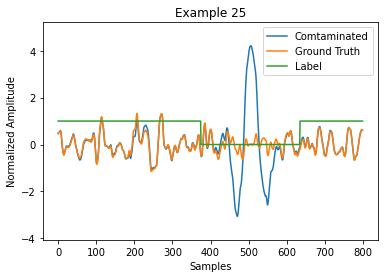

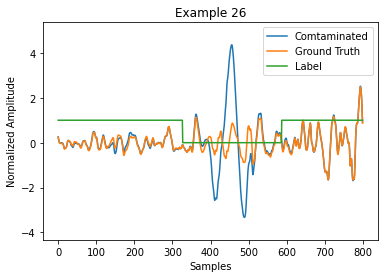

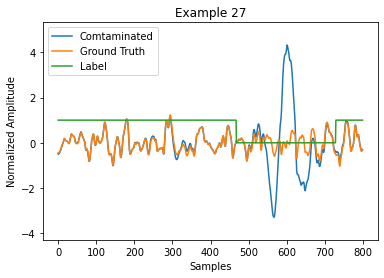

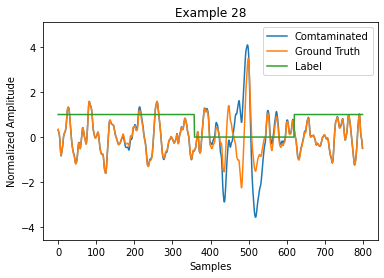

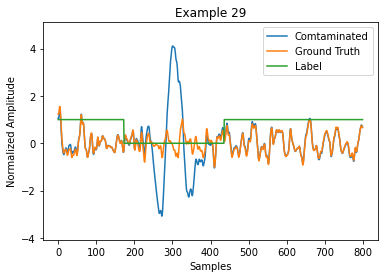

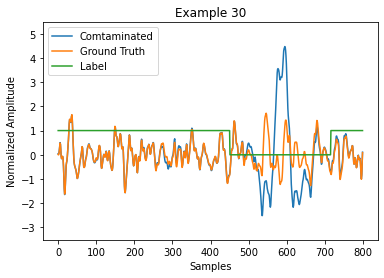

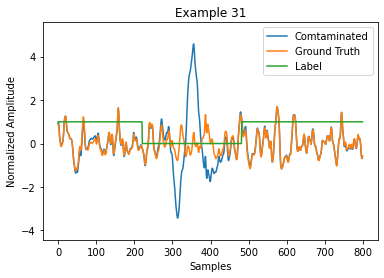

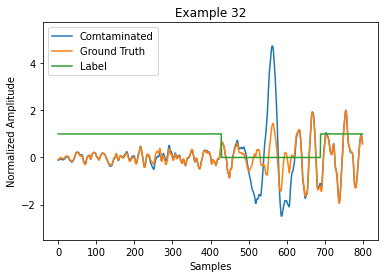

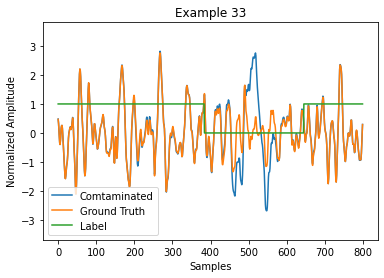

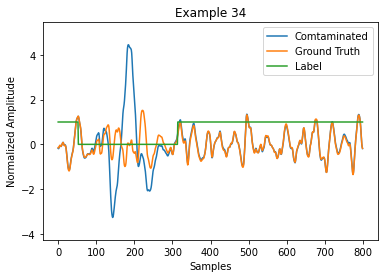

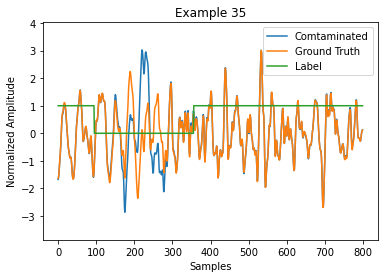

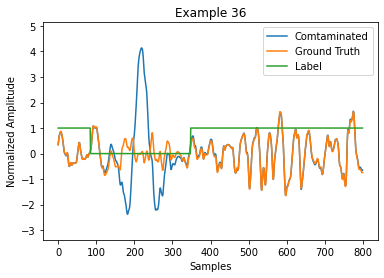

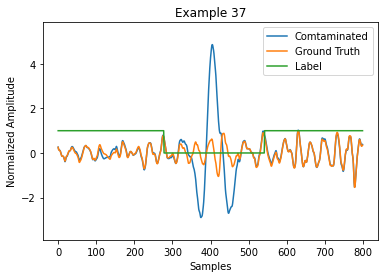

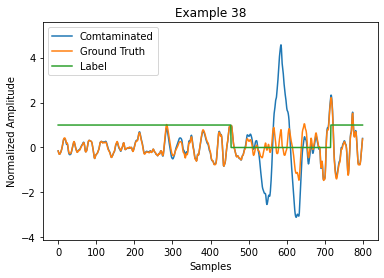

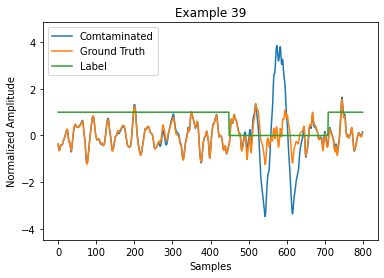

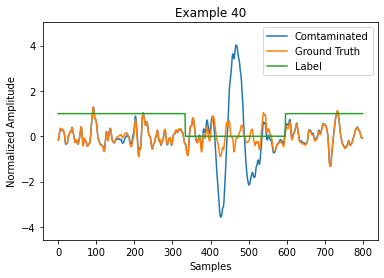

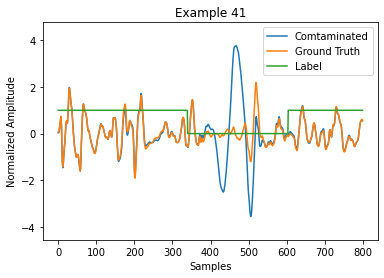

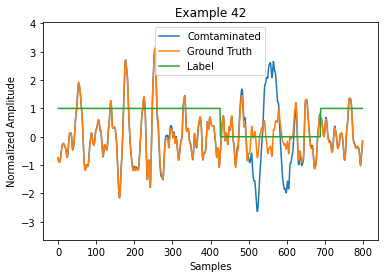

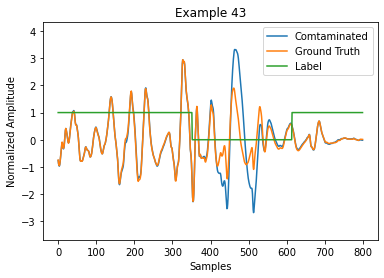

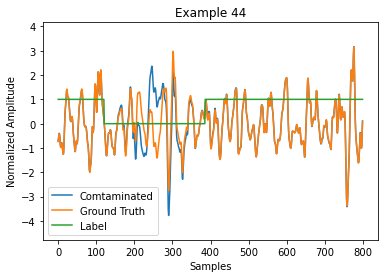

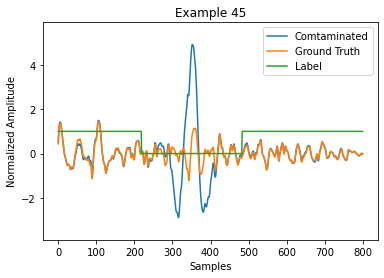

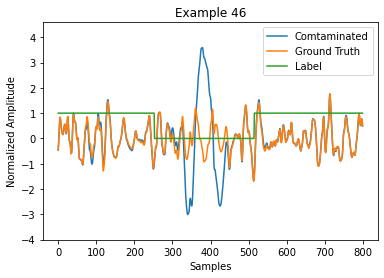

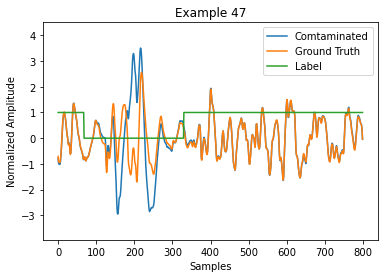

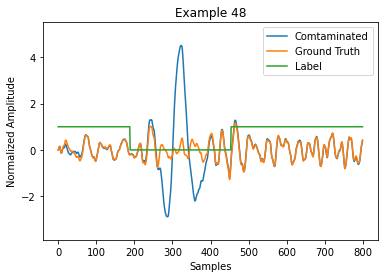

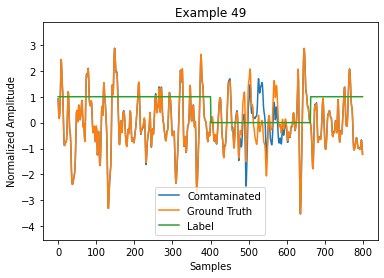

In [110]:
# Plot examples of contaminated and ground truth data
for i in range(50):
    plt.plot(x[i])
    plt.plot(y[i])
    plt.plot(label[i])
    plt.legend(['Comtaminated', 'Ground Truth', 'Label'])
    plt.xlabel('Samples')
    plt.ylabel('Normalized Amplitude')
    plt.title('Example ' + str(i))
    plt.ylim([np.min(x[i])-1, np.max(x[i]+1)])
    plt.show()

In [111]:
# Shuffle the dataset
x, y, label = shuffle(x, y, label)

# Define number of samples to be placed in validation dataset
cut = 1000

# Validation Split
x_val = x[:cut]
y_val = y[:cut]
label_val = label[:cut]

x_train = x[cut:]
y_train = y[cut:]
label_train = label[cut:]

# For ECGbe-GAN, shuffle the contaminated and ground truth data separately 
x_gan, label_gan = shuffle(x_train, label_train)
y_gan = shuffle(y_train)

print("Validation Shape:", x_val.shape)
print("Supervised Shape:", x_train.shape)
print("GAN Shape:", x_gan.shape)

Validation Shape: (1000, 800, 1)
Supervised Shape: (5000, 800, 1)
GAN Shape: (5000, 800, 1)


In [112]:
# np.save('../../Data/Training Data/Validation/x_val.npy', x_val)
# np.save('../../Data/Training Data/Validation/y_val.npy', y_val)
# np.save('../../Data/Training Data/Validation/label_val.npy', label_val)

# np.save('../../Data/Training Data/ECGbe-GAN/x_syn.npy', x_gan)
# np.save('../../Data/Training Data/ECGbe-GAN/y_syn.npy', y_gan)
# np.save('../../Data/Training Data/ECGbe-GAN/label_syn.npy', label_gan)

# np.save('../../Data/Training Data/Supervised/x_train.npy', x_train)
# np.save('../../Data/Training Data/Supervised/y_train.npy', y_train)
# np.save('../../Data/Training Data/Supervised/label_train.npy', label_train)